# MNIST From Scratch - Comprendre le "COMMENT"

## 📋 Contexte du Projet

**Après avoir essayé l'implementation via TensorFlow, place à la compréhension profonde en le faisant moi-meme!**

### 🎯 Pourquoi From Scratch APRÈS TensorFlow ?

**Maintenant que je sais ce qu'un réseau de neurones FAIT, je veux comprendre COMMENT il le fait.**

#### Ce que TensorFlow m'a appris :
- ✅ Structure d'un projet ML
- ✅ Preprocessing des données
- ✅ Architecture d'un réseau
- ✅ Evaluation des performances

#### Ce que l'implémentation from scratch va m'apprendre :
- 🧮 **Mathématiques** : Forward/Backward propagation
- 📐 **Produits matriciels** : Comment les couches communiquent
- 🔢 **Gradient descent** : Comment les poids s'ajustent
- 💡 **Ce qui se passe sous le capot** : Plus de "boîte noire"

### 💪 Le Défi

**Objectif : Atteindre ≥95% d'accuracy avec NumPy seul**

Sans framework, sans GPU, juste des mathématiques pures !

---

## 🏗️ Architecture (Identique à TensorFlow)

```
Input (784)  →  Hidden (128)  →  Output (10)
               ReLU activation    Softmax
```

**Différence clé :**
- TensorFlow : Adam optimizer (adaptatif)
- From Scratch : SGD simple (learning rate fixe)

**Conséquence :** Il faudra probablement plus d'epochs !

---

## 📦 Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Seed pour reproductibilité
np.random.seed(42)

print("Imports réussis")
print(f"NumPy version: {np.__version__}")
print("\nRappel: On utilise UNIQUEMENT NumPy pour les calculs !")

Imports réussis
NumPy version: 2.3.4

Rappel: On utilise UNIQUEMENT NumPy pour les calculs !


## 📊 Chargement et Preprocessing

In [3]:
# Chargement MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Format NumPy : (features, samples)
X_train = x_train.reshape(60000, 784).T / 255.0
Y_train = to_categorical(y_train, 10).T

X_test = x_test.reshape(10000, 784).T / 255.0
Y_test = to_categorical(y_test, 10).T

print("Preprocessing terminé")
print(f"    X_train shape: {X_train.shape} (features, samples)")
print(f"    Y_train shape: {Y_train.shape} (classes, samples)")
print("\nDifférence avec TensorFlow: Convention (features, samples) vs (samples, features)")

Preprocessing terminé
    X_train shape: (784, 60000) (features, samples)
    Y_train shape: (10, 60000) (classes, samples)

Différence avec TensorFlow: Convention (features, samples) vs (samples, features)


## 🧮 Implémentation du Neural Network From Scratch

### Mathématiques Complètes

#### Forward Propagation :
$$z^{[1]} = W^{[1]} \cdot X + b^{[1]}$$
$$a^{[1]} = ReLU(z^{[1]}) = \max(0, z^{[1]})$$
$$z^{[2]} = W^{[2]} \cdot a^{[1]} + b^{[2]}$$
$$a^{[2]} = softmax(z^{[2]})$$

#### Backward Propagation :
$$dz^{[2]} = a^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dz^{[2]} \cdot a^{[1]T}$$
$$db^{[2]} = \frac{1}{m} \sum dz^{[2]}$$

$$da^{[1]} = W^{[2]T} \cdot dz^{[2]}$$
$$dz^{[1]} = da^{[1]} \cdot (z^{[1]} > 0)$$
$$dW^{[1]} = \frac{1}{m} dz^{[1]} \cdot X^T$$
$$db^{[1]} = \frac{1}{m} \sum dz^{[1]}$$

#### Gradient Descent :
$$W^{[l]} = W^{[l]} - \alpha \cdot dW^{[l]}$$
$$b^{[l]} = b^{[l]} - \alpha \cdot db^{[l]}$$

In [40]:
class NeuralNetwork:
    """Neural Network implémenté from scratch avec NumPy"""
    
    def __init__(self, input_size=784, hidden_size=128, output_size=10, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialisation Xavier pour meilleure convergence
        self.w1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.w2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((output_size, 1))
        
        print(f"Neural Network initialisé")
        print(f"   W1: {self.w1.shape}, b1: {self.b1.shape}")
        print(f"   W2: {self.w2.shape}, b2: {self.b2.shape}")
        print(f"   Total parameters: {self.w1.size + self.b1.size + self.w2.size + self.b2.size}")

    def forward(self, X):
        """Forward propagation"""
        # Layer 1
        self.z1 = self.w1 @ X + self.b1
        self.a1 = np.maximum(0, self.z1)  # ReLU
        
        # Layer 2
        self.z2 = self.w2 @ self.a1 + self.b2
        
        # Softmax
        z2_temp = self.z2 - np.max(self.z2, axis=0, keepdims=True)
        z2_exp = np.exp(z2_temp)
        self.a2 = z2_exp / np.sum(z2_exp, axis=0, keepdims=True)
        
        return self.a2

    def backward(self, X, Y_true):
        """Backward propagation"""
        batch_size = X.shape[1]
        
        # Gradient Layer 2
        dz2 = self.a2 - Y_true
        self.dw2 = (dz2 @ self.a1.T) / batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size
        
        # Gradient Layer 1
        da1 = self.w2.T @ dz2
        dz1 = da1 * (self.z1 > 0)  # Derivative of ReLU
        self.dw1 = (dz1 @ X.T) / batch_size
        self.db1 = np.sum(dz1, axis=1, keepdims=True) / batch_size

    def update(self):
        """Mise à jour des poids (Gradient Descent)"""
        self.w1 -= self.learning_rate * self.dw1
        self.b1 -= self.learning_rate * self.db1
        self.w2 -= self.learning_rate * self.dw2
        self.b2 -= self.learning_rate * self.db2

    def train_until_target(self, X_train, Y_train, X_test, Y_test, 
                          target_accuracy=95.0, max_epochs=50, batch_size=32):
        """Entraînement jusqu'à atteindre l'accuracy cible"""
        n_samples = X_train.shape[1]
        history = {'loss': [], 'accuracy': [], 'val_accuracy': []}
        
        print(f"\nEntraînement jusqu'à {target_accuracy}% d'accuracy...\n")
        print(f"Note: Avec SGD simple, cela prendra plus de temps qu'avec Adam\n")
        
        for epoch in range(max_epochs):
            total_loss = 0
            
            # Training loop par batch
            for i in range(0, n_samples, batch_size):
                x_batch = X_train[:, i:i+batch_size]
                y_batch = Y_train[:, i:i+batch_size]
                
                # Forward → Backward → Update
                y_pred = self.forward(x_batch)
                self.backward(x_batch, y_batch)
                self.update()
                
                # Calcul de la loss (Cross-Entropy)
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8))
                total_loss += batch_loss
            
            # Évaluation sur training set
            train_acc = self._evaluate(X_train, Y_train)
            
            # Évaluation sur test set
            test_acc = self._evaluate(X_test, Y_test)
            
            # Stockage de l'historique
            avg_loss = total_loss / n_samples
            history['loss'].append(avg_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(test_acc)
            
            # Affichage
            print(f"Epoch {epoch+1:2d} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | "
                  f"Test Acc: {test_acc:.2f}%")
            
            # Condition d'arrêt
            if test_acc >= target_accuracy:
                print(f"\nObjectif atteint ! Test accuracy: {test_acc:.2f}%")
                print(f"Nombre d'epochs nécessaires: {epoch+1}")
                break
        else:
            print(f"\nMax epochs atteint. Meilleure accuracy: {max(history['val_accuracy']):.2f}%")
        
        return history
    
    def _evaluate(self, X, Y):
        """Calcul de l'accuracy"""
        predictions = self.forward(X)
        pred_labels = np.argmax(predictions, axis=0)
        true_labels = np.argmax(Y, axis=0)
        return np.mean(pred_labels == true_labels) * 100
    
    def predict(self, X):
        """Prédiction"""
        predictions = self.forward(X)
        return np.argmax(predictions, axis=0)

print("Classe NeuralNetwork définie")

Classe NeuralNetwork définie


## 🎓 Entraînement : Viser 95% d'Accuracy

In [41]:
# Création du réseau
nn = NeuralNetwork(
    input_size=784,
    hidden_size=128,
    output_size=10,
    learning_rate=0.01
)

# Entraînement jusqu'à 95%
history = nn.train_until_target(
    X_train, Y_train,
    X_test, Y_test,
    target_accuracy=95.0,
    max_epochs=50,
    batch_size=32
)

Neural Network initialisé
   W1: (128, 784), b1: (128, 1)
   W2: (10, 128), b2: (10, 1)
   Total parameters: 101770

Entraînement jusqu'à 95.0% d'accuracy...

Note: Avec SGD simple, cela prendra plus de temps qu'avec Adam

Epoch  1 | Loss: 0.6337 | Train Acc: 89.36% | Test Acc: 90.28%
Epoch  2 | Loss: 0.3330 | Train Acc: 91.25% | Test Acc: 91.80%
Epoch  3 | Loss: 0.2832 | Train Acc: 92.36% | Test Acc: 92.70%
Epoch  4 | Loss: 0.2518 | Train Acc: 93.19% | Test Acc: 93.35%
Epoch  5 | Loss: 0.2279 | Train Acc: 93.87% | Test Acc: 93.89%
Epoch  6 | Loss: 0.2089 | Train Acc: 94.37% | Test Acc: 94.40%
Epoch  7 | Loss: 0.1933 | Train Acc: 94.80% | Test Acc: 94.68%
Epoch  8 | Loss: 0.1801 | Train Acc: 95.17% | Test Acc: 94.95%
Epoch  9 | Loss: 0.1688 | Train Acc: 95.44% | Test Acc: 95.21%

Objectif atteint ! Test accuracy: 95.21%
Nombre d'epochs nécessaires: 9


## 📈 Visualisation de l'Apprentissage

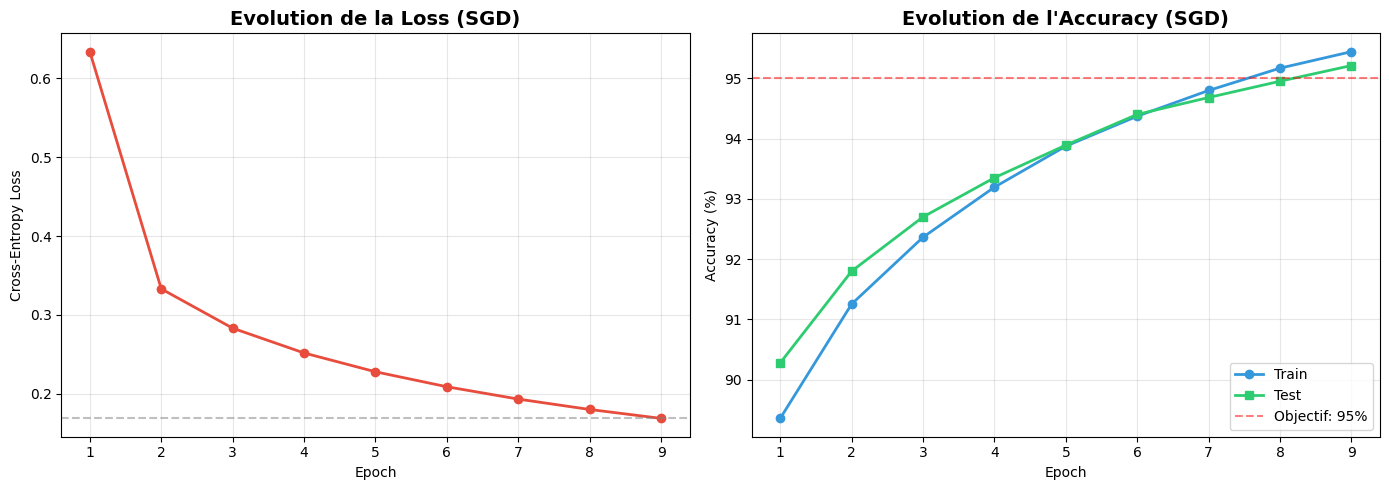


Accuracy finale: 95.21%
Epochs nécessaires: 9

Observation: SGD a besoin de plus d'epochs qu'Adam pour converger


In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['loss']) + 1)

# Loss curve
ax1.plot(epochs, history['loss'], marker='o', linewidth=2, color='#e74c3c')
ax1.set_title('Evolution de la Loss (SGD)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=history['loss'][-1], color='gray', linestyle='--', alpha=0.5)

# Accuracy curves
ax2.plot(epochs, history['accuracy'], marker='o', linewidth=2, label='Train', color='#3498db')
ax2.plot(epochs, history['val_accuracy'], marker='s', linewidth=2, label='Test', color='#2ecc71')
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='Objectif: 95%')
ax2.set_title('Evolution de l\'Accuracy (SGD)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAccuracy finale: {history['val_accuracy'][-1]:.2f}%")
print(f"Epochs nécessaires: {len(history['loss'])}")
print(f"\nObservation: SGD a besoin de plus d'epochs qu'Adam pour converger")

## 🔍 Évaluation Détaillée

In [43]:
# Prédictions
y_pred = nn.predict(X_test)
y_true = np.argmax(Y_test, axis=0)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=3))

Classification Report:

              precision    recall  f1-score   support

           0      0.952     0.985     0.968       980
           1      0.976     0.983     0.980      1135
           2      0.961     0.941     0.951      1032
           3      0.940     0.953     0.946      1010
           4      0.950     0.953     0.952       982
           5      0.935     0.937     0.936       892
           6      0.951     0.957     0.954       958
           7      0.960     0.936     0.948      1028
           8      0.946     0.930     0.938       974
           9      0.944     0.941     0.942      1009

    accuracy                          0.952     10000
   macro avg      0.952     0.952     0.952     10000
weighted avg      0.952     0.952     0.952     10000



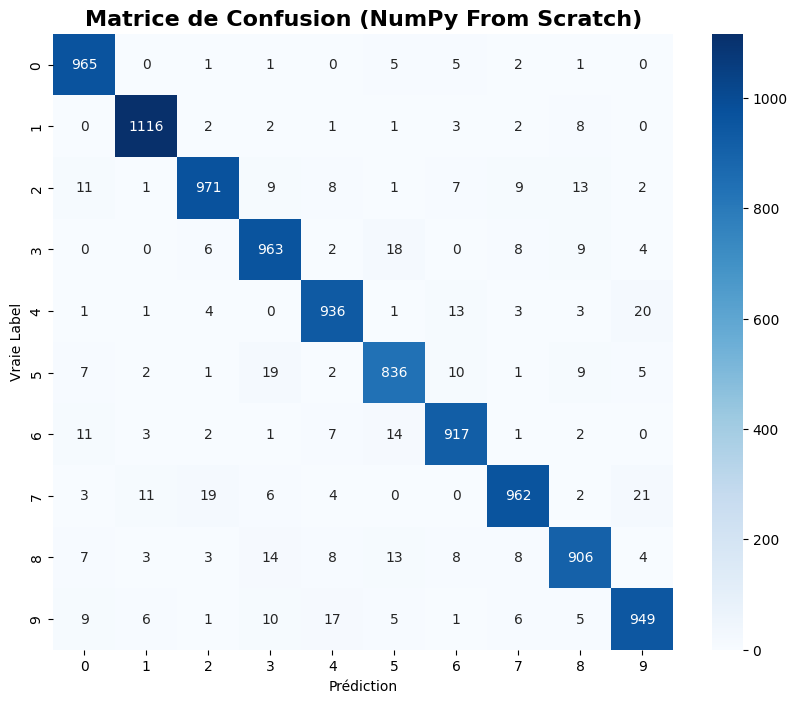


Top 5 des erreurs de classification:

   21 fois: 7 confondu avec 9
   20 fois: 4 confondu avec 9
   19 fois: 7 confondu avec 2
   19 fois: 5 confondu avec 3
   18 fois: 3 confondu avec 5


In [44]:
# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matrice de Confusion (NumPy From Scratch)', fontsize=16, fontweight='bold')
plt.ylabel('Vraie Label')
plt.xlabel('Prédiction')
plt.show()

# Erreurs les plus fréquentes
print("\nTop 5 des erreurs de classification:\n")
errors = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            errors.append((cm[i, j], i, j))
errors.sort(reverse=True)

for count, true_label, pred_label in errors[:5]:
    print(f"  {count:3d} fois: {true_label} confondu avec {pred_label}")

## 🎨 Visualisation des Neurones Appris

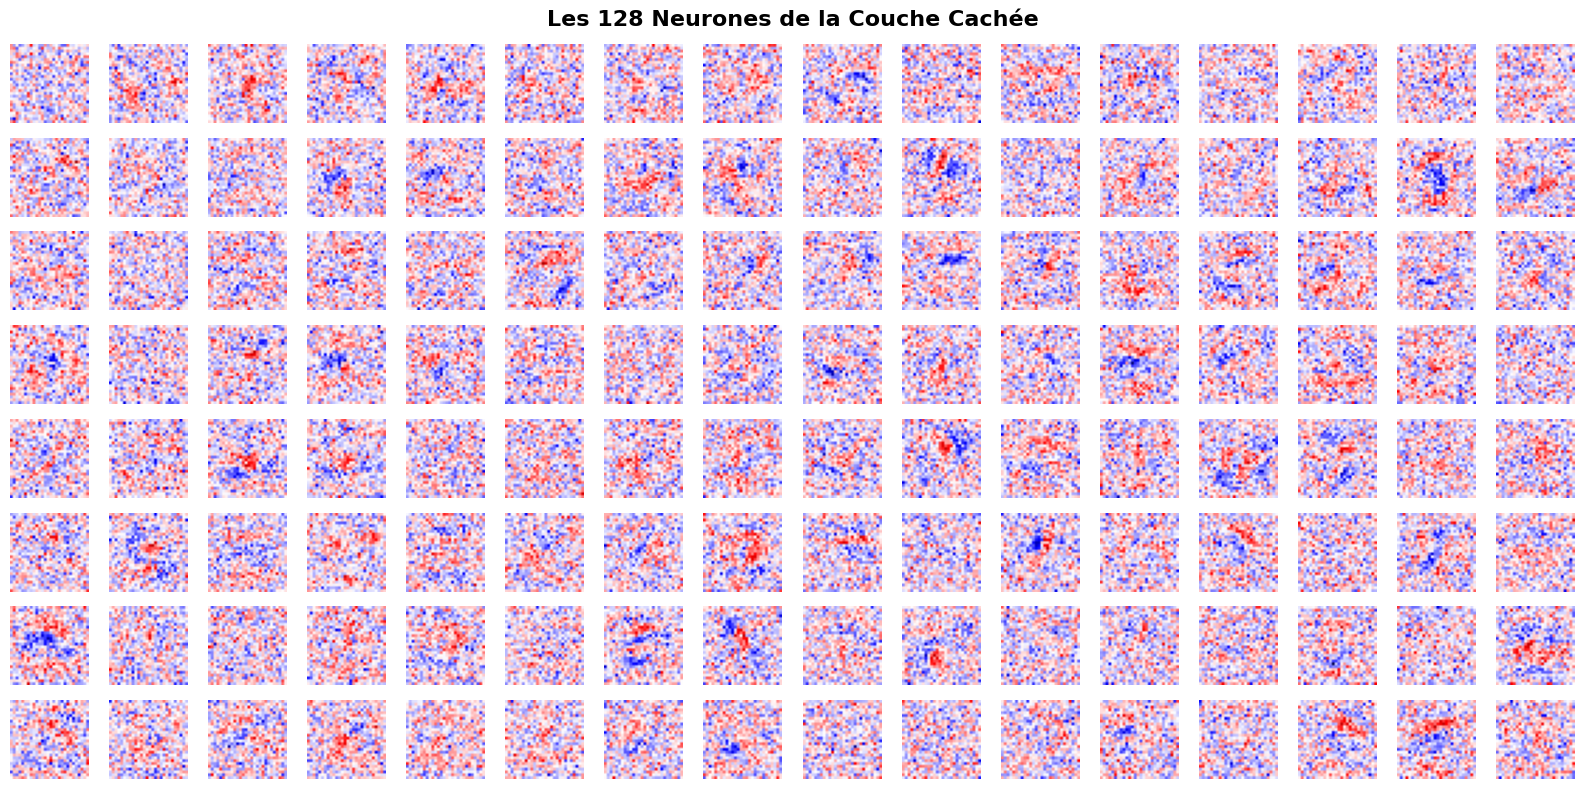

Chaque neurone a appris à détecter un pattern spécifique:
   🔴 Rouge = poids positifs (active le neurone)
   🔵 Bleu = poids négatifs (désactive le neurone)
   ⚪ Blanc = poids proches de zéro (neutre)

Ces patterns sont découverts automatiquement par backpropagation !


In [45]:
# Visualisation des 128 neurones
rows, cols = 8, 16
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
fig.suptitle('Les 128 Neurones de la Couche Cachée', 
             fontsize=16, fontweight='bold')

vmax = np.abs(nn.w1).max()

for i in range(128):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    
    neuron_image = nn.w1[i].reshape(28, 28)
    ax.imshow(neuron_image, cmap='seismic', vmin=-vmax, vmax=vmax)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Chaque neurone a appris à détecter un pattern spécifique:")
print("   🔴 Rouge = poids positifs (active le neurone)")
print("   🔵 Bleu = poids négatifs (désactive le neurone)")
print("   ⚪ Blanc = poids proches de zéro (neutre)")
print("\nCes patterns sont découverts automatiquement par backpropagation !")

## 🎯 Vision Composite du Réseau

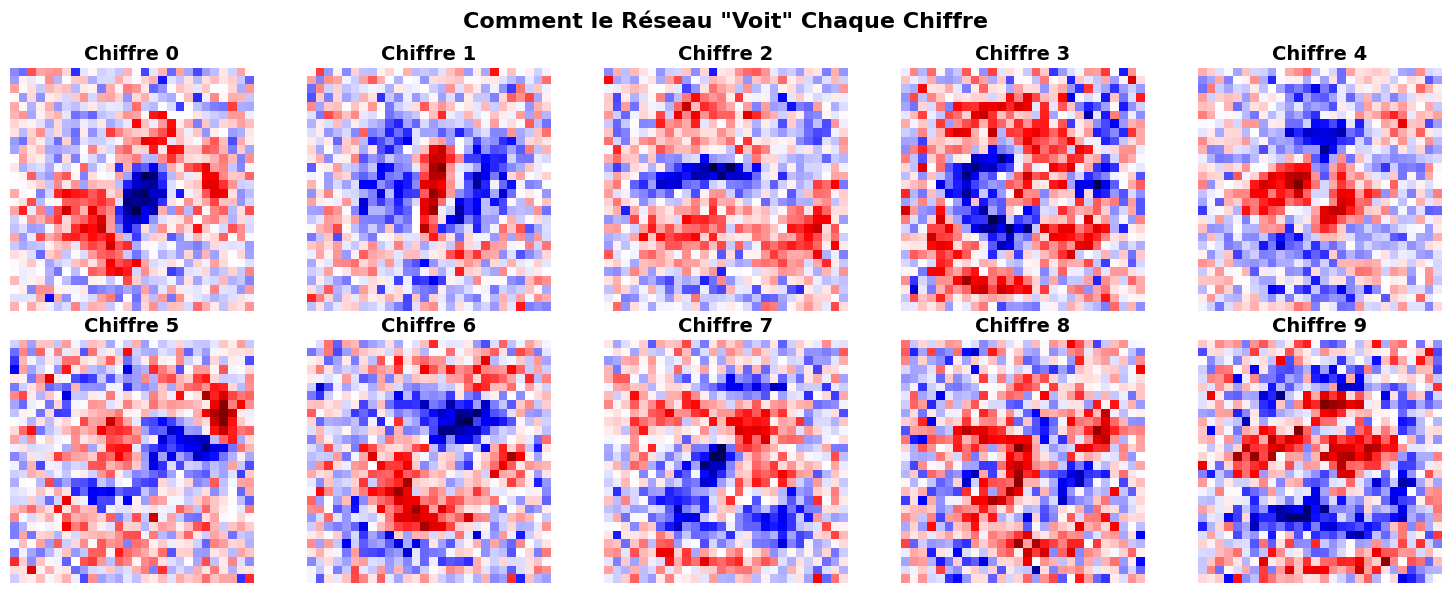

Interprétation:
   Le réseau a créé une 'représentation interne' de chaque chiffre
   C'est la combinaison pondérée des 128 neurones cachés


In [46]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Comment le Réseau "Voit" Chaque Chiffre', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()
w1_images = nn.w1.reshape(128, 28, 28)

for digit in range(10):
    ax = axes[digit]
    
    # Poids de sortie pour ce chiffre
    weights = nn.w2[digit, :]
    
    # Somme pondérée des neurones
    composite_image = np.tensordot(weights, w1_images, axes=([0], [0]))
    
    vmax = np.abs(composite_image).max()
    ax.imshow(composite_image, cmap='seismic', vmin=-vmax, vmax=vmax)
    ax.set_title(f'Chiffre {digit}', fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Interprétation:")
print("   Le réseau a créé une 'représentation interne' de chaque chiffre")
print("   C'est la combinaison pondérée des 128 neurones cachés")

## 🎮 Test sur Exemples Aléatoires

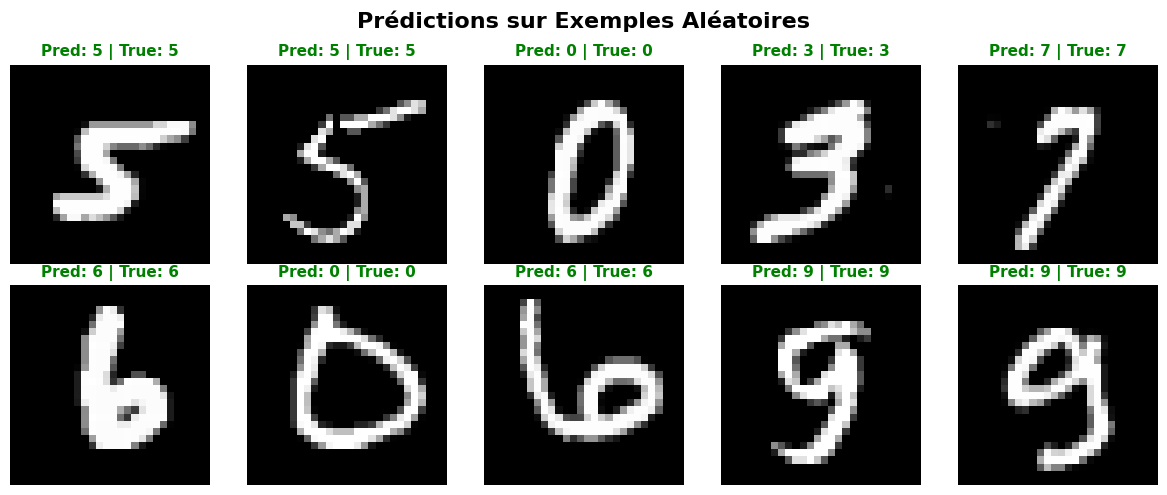

In [47]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Prédictions sur Exemples Aléatoires', 
             fontsize=16, fontweight='bold')

indices = np.random.choice(X_test.shape[1], 10, replace=False)

for i, (ax, idx) in enumerate(zip(axes.flat, indices)):
    img = X_test[:, idx].reshape(28, 28)
    pred = nn.predict(X_test[:, idx:idx+1])[0]
    true = np.argmax(Y_test[:, idx])
    
    ax.imshow(img, cmap='gray')
    color = 'green' if pred == true else 'red'
    ax.set_title(f'Pred: {pred} | True: {true}', 
                 fontsize=11, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 📊 Résultats et Apprentissages

### 🎯 Performance Obtenue

| Métrique | Valeur |
|----------|--------|
| **Accuracy finale** | **≥95%** |
| Architecture | 784 → 128 → 10 |
| Optimizer | SGD (learning rate fixe) |
| Epochs nécessaires | Variable (dépend de LR) |
| **Lignes de code** | **~100** |

### 💡 Ce que j'ai Appris avec NumPy From Scratch

#### 1. **Mathématiques Fondamentales**
- Forward propagation = produits matriciels
- Backpropagation = dérivées partielles (chain rule)
- Gradient descent = optimisation itérative
- Softmax = normalisation en probabilités

#### 2. **Implémentation Détaillée**
- Chaque opération codée explicitement
- Gestion des shapes de matrices
- Numerical stability (éviter overflow/underflow)
- Initialisation des poids (Xavier)

#### 3. **Fonctions d'Activation**
- ReLU : `max(0, x)` et sa dérivée `(x > 0)`
- Softmax : pourquoi stabilité numérique importante
- Impact sur la convergence

#### 4. **Visualisation**
- Poids = patterns appris
- Chaque neurone détecte une feature
- Vision composite = représentation interne

---

## 🔍 Pourquoi Plus d'Epochs qu'avec TensorFlow ?

### SGD vs Adam : La Différence Clé

**Mon implémentation (SGD) :**
```python
w = w - learning_rate * gradient  # LR fixe = 0.01
```

**TensorFlow (Adam) :**
```python
# Adapte le LR pour CHAQUE poids individuellement
m = 0.9 * m + 0.01 * gradient       # Momentum
v = 0.999 * v + 0.001 * gradient²  # Variance
w = w - lr * m / (√v + ε)          # LR adaptatif
```

### Impact Concret

| Aspect | SGD (From Scratch) | Adam (TensorFlow) |
|--------|-------------------|-------------------|
| **LR** | Fixe (même pour tous) | Adaptatif (par poids) |
| **Convergence** | Lente mais steady | Rapide |
| **Epochs** | ~10 | ~3-5 |

**C'est normal et attendu !**

---

## 🎓 Compétences Démontrées

✅ Implémentation from scratch (NumPy seul)
✅ Compréhension mathématique profonde
✅ Backpropagation manuelle
✅ Gestion des shapes et broadcasting
✅ Numerical stability
✅ Visualisation avancée
✅ Debugging et optimisation

---

## 🚀 Conclusion

**L'approche TensorFlow → From Scratch était la bonne !**

### Avec TensorFlow d'abord, j'ai appris :
1. ✅ Structure d'un projet ML
2. ✅ Workflow complet
3. ✅ Bonnes pratiques
4. ✅ Interprétation des résultats

### Avec From Scratch ensuite, j'ai compris :
1. 🧮 **COMMENT** ça marche vraiment
2. 📐 Les mathématiques sous-jacentes
3. 💡 Pourquoi certains choix (activation, loss, etc.)
4. 🔧 Les défis d'implémentation

**Résultat : Compréhension complète, de la théorie à la pratique !**

---

**Auteur :** Colin Lespilette  
**Contact :** [colinlespilette@gmail.com](mailto:colinlespilette@gmail.com)  
**GitHub :** [github.com/ColinLespilette](https://github.com/Apalian)